# <center>Data Science Project Part 3:  Safety </center>
<center>DATA 558, Spring 2021</center>
<center>Instructor: Zaid Harchaoui</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>

## Instructions

Welcome to the final leg DATA 558 project! Let's begin with a brief reminder of the format: each week, you will receive a notebook containing a data analysis involving the Animals with Attributes 2 (AwA2) dataset. The notebook will claim to meet some statistical or machine learning criterion relevant to the week's lecture topic. Your goal is to investigate and critique this analysis.

__Objective__: This notebook claims to implement a model for classification of the AwA2 animals that is safe and robust to distributional shift. There are no mistakes in the syntax; each cell runs and returns a plausible result. However, there can be several mistakes from a statistical and conceptual perspective. Working with your partner, you are expected to provide (1) a list of these mistakes and (2) a justification for why each item you list in (1) is a mistake. Justification can take many forms, including but not limited to a __detailed comment__, a __code example showing the problem__, or (perhaps simplest in some cases) a __direct fix of the code and demonstration that the problem is resolved__.


__Deliverable__: Please submit to Gradescope __a copy of this notebook with your findings and comments__. Please use the cell below to summarize the mistakes you found. That is, for each mistake, write a (short) indication of what the mistake is and where you found it. For every item in this summary, you are expected to provide a matching justification in the notebook with the same label - e.g. for mistake `A`, include in the notebook a justification (again, this may be a comment, code block, etc.) at the location where this mistake is made, also labeled `A`.

#### Name: Apoorv Sharma
#### Partner: Alyson Suchodolski
#### Summary of findings:

    A: X_val and y_val should be left as unshifted.

    B: Bug in `subsample` function. We should be taking the minimum count of all classes, and then finding the proportion using this.
    
    C: Comparing the safe and unsafe logistic regression models
    
    D: Data needs to be normalized before performing PCA
    
    E: Accuray is not 100% after bug-fixes

In [96]:
import numpy as np
import matplotlib.pyplot as plt

We use a featurized version of the AwA2 dataset, where inputs are vectorized images, and outputs are labels. The problem is reduced to binary labels, classifying between one of two animals. We apply a simulated "shift" in distribution by resampling the classes to be of a different proportion. Then, we can check whether our trained model performs well on both the shifted and unshifted dataset. 

## Finding B

We should be finding the minimum count of all the classes and then multiplying this by the proportion, rather than multiplying the proportion by the size of that class

In [97]:
def subsample(X, y, proportions):
    """
    proportions is a numpy array of length n_classes, specifying the proportion of each class to remain.
    """
    classes, counts = np.unique(y, return_counts=True)
    max_size = np.min(counts)
    n = len(y)
    X_sub = []
    y_sub = []
    
    for i, class_ in enumerate(classes):
        class_idx = np.arange(n)[y == class_]
        # n_class = int(proportions[i] * len(class_idx)) # Finding B -- Mistake
        n_class = int(proportions[i] * max_size) #Finding B -- Bug Fix
        if n_class > 0:
            idx = np.random.choice(class_idx, n_class, replace=False)
            X_sub.append(X[idx])
            y_sub.append(y[idx])
    
    x_new, y_new = np.concatenate(X_sub), np.concatenate(y_sub)
    
    # Shuffle the arrays
    shuffler = np.random.permutation(len(x_new))
    x_new_shuffled = x_new[shuffler]
    y_new_shuffled = y_new[shuffler]
        
    return x_new_shuffled, y_new_shuffled

In [98]:
X_train_bin = np.load("X_train_bin.npy")
X_val_bin = np.load("X_val_bin.npy")
y_train_bin = np.load("y_train_bin.npy")
y_val_bin = np.load("y_val_bin.npy")

In [99]:
print(f'X_train shape: {X_train_bin.shape}')
print(f'X_val_bin shape: {X_val_bin.shape}')

X_train shape: (1811, 1126)
X_val_bin shape: (466, 1126)


In [100]:
classes, counts = np.unique(y_train_bin, return_counts=True)
print(f'y_train_bin: Classes" {classes}, Counts: {counts}')

classes, counts = np.unique(y_val_bin, return_counts=True)
print(f'y_val_bin: Classes" {classes}, Counts: {counts}')

y_train_bin: Classes" [0 1], Counts: [1035  776]
y_val_bin: Classes" [0 1], Counts: [268 198]


## Finding D

We need to normalize the X values before we perform PCA on them.

PCA calculates a new projection of the data set. Since the new axis is based on the std dev, a variable with high std dev will have a higher weight. Thus normalizing all samples will allow the features to have the same std dev, thus all variables have the same weight and PCA will calculate relevant axis.

In [101]:
from sklearn.preprocessing import normalize, StandardScaler
X_train_bin = normalize(X_train_bin, axis=0)
X_val_bin = normalize(X_val_bin, axis=0)

# scaler = StandardScaler().fit(X_train_bin)
# X_train_bin = scaler.transform(X_train_bin)
# X_val_bin = scaler.transform(X_val_bin)

In [102]:
X_train_bin

array([[-0.0063071 ,  0.05294942, -0.03381288, ..., -0.02026196,
         0.01745847, -0.01357387],
       [-0.00118385, -0.00446584, -0.00796123, ...,  0.00754735,
         0.05896901,  0.02127566],
       [-0.00450652,  0.01490339, -0.02278596, ...,  0.01215168,
         0.00960716, -0.0086876 ],
       ...,
       [-0.02138114,  0.00060919, -0.02562518, ...,  0.01128563,
        -0.00261714, -0.00395759],
       [ 0.00449711,  0.01989891, -0.02115538, ..., -0.03156998,
        -0.0206712 , -0.00067584],
       [-0.01403798,  0.01101818, -0.02319064, ...,  0.03875886,
         0.01112015, -0.01114064]])

In [103]:
# np.linalg.norm(X_train_bin[:, 1])
np.mean(X_train_bin[:, 1])
np.std(X_train_bin[:, 1])

0.017334828054012232

## Finding A

We should leave `X_val` and `y_val` as unshifted. This will allow us to actually compare the unshifted and shifted validation testsets.

Moreover, we take a slightly more extreme shif in `X_train` and `y_train` to show that the model is not safe.

In [104]:
from sklearn.decomposition import PCA

# Shuffle the arrays
shuffler = np.random.permutation(len(X_train_bin))
X_train_bin = X_train_bin[shuffler]
y_train_bin = y_train_bin[shuffler]

shuffler = np.random.permutation(len(X_val_bin))
X_val_bin = X_val_bin[shuffler]
y_val_bin = y_val_bin[shuffler]

# Apply shifts.
np.random.seed(123)

# Finding A -- We should leave X_val as unshifted
# X_train, y_train = subsample(X_train_bin, y_train_bin, [0.7, 0.3]) # Why sample X_train_bin as well ??
# X_val, y_val = subsample(X_val_bin, y_val_bin, [0.7, 0.3])
# # X_val_shift, y_val_shift = subsample(X_val_bin, y_val_bin, [0.5, 0.5]) # Why is this different ??
# X_val_shift, y_val_shift = subsample(X_val_bin, y_val_bin, [0.1, 0.9]) # Why is this different ??

# Finding A -- correction, we leave X_val as unshifted
X_train, y_train = subsample(X_train_bin, y_train_bin, [0.8, 0.2])
# X_train, y_train = X_train_bin, y_train_bin
X_val, y_val = X_val_bin, y_val_bin
X_val_shift, y_val_shift = subsample(X_val_bin, y_val_bin, [0.1, 0.9])

# Apply PCA.
pca = PCA().fit(X_train, y_train)
# pca = PCA().fit(X_train_bin, y_train_bin)

# Check for PCA -- comparison
cumulative = 0
for i, var in enumerate(pca.explained_variance_ratio_):
    cumulative += var
    if cumulative > 0.90:
        print(
            "%0.3f percent of variance explained by %d/%d dimensions."
            % (cumulative, i, X_train.shape[1])
        )
        n_components = i
        break
        
pca = PCA(n_components=n_components).fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_val_shift = pca.transform(X_val_shift)

n_classes = len(np.unique(y_train))

0.901 percent of variance explained by 440/1126 dimensions.


In [105]:
def counts(y, freq=False):
    classes = np.arange(n_classes)
    ret = np.array([len(y[y==class_]) for class_ in classes])
    if freq:
        return ret / ret.sum()
    return ret

def plot_class_hist(y_train, y_val):

    x = np.arange(len(np.unique(y_train)))
    y1 = counts(y_train, freq=True)
    y2 = counts(y_val, freq=True)
#     y3 = counts(y_test, freq=True)

    fig, ax = plt.subplots(figsize=(7,5))
    width = 0.25
    ax.bar(x-width, y1, edgecolor="k", width=width, color='mediumturquoise', align='center', label="train")
    ax.bar(x, y2, edgecolor="k", width=width, color='gold', align='center', label="val")
    # ax.bar(x+width, y3, edgecolor="k", width=width, color='red', align='center', label="test")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Class 0", "Class 1"])
    plt.legend(loc="upper right")

    plt.show()

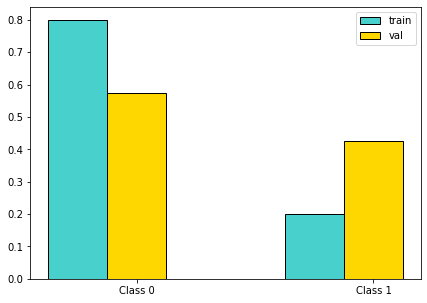

In [106]:
plot_class_hist(y_train, y_val)

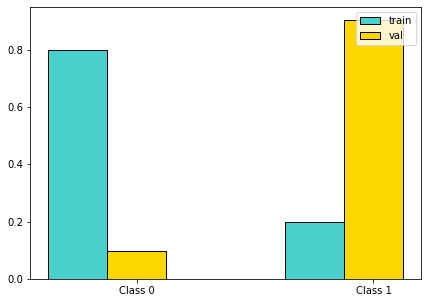

In [107]:
plot_class_hist(y_train, y_val_shift)

In [108]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver="liblinear", max_iter=300).fit(X_train, y_train)

As seen below, the classifier maintains accuracy on the shifted validation set, even though the probabilities of each class have shifted significantly. In fact, this classifier does not even have to trade robustness for accuracy, as its accuracy is $100\%$ on both validation sets!

## Finding E

Now that we have applied the bug-fixes, we see that the accuray is not 100%. Moreover, we also see that the model is not safe/robust. The accuracy of the shifted validation set is much lower compared to the accuracy of the unshifted validation set.

In [109]:
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc

print("Accuracy:", accuracy_score(y_val, lr.predict(X_val)))
print("Shifted Accuracy:", accuracy_score(y_val_shift, lr.predict(X_val_shift)))

Accuracy: 0.8776824034334764
Shifted Accuracy: 0.7614213197969543


In [110]:
print("Precision:", precision_score(y_val, lr.predict(X_val)))
print("Shifted Precision:", precision_score(y_val_shift, lr.predict(X_val_shift)))

Precision: 1.0
Shifted Precision: 1.0


## Finding C

We now create a more robust model using the `DRLogisticRegression` class found in the `SPQR` library.

Clearly, using this safer model, we can see that the accuracy values are much higher compared to the simple Logistic Regression model that was given above.

In [111]:
from spqr import DRLogisticRegression
# from spqr.measures import quantile, superquantile

super_clf = DRLogisticRegression(p=0.8, fit_intercept=False)
super_clf.fit(X_train, y_train) # TODO: let fit return the classifier

y_hat_tr = super_clf.predict(X_train)
y_hat_val = super_clf.predict(X_val)
y_hat_val_shift = super_clf.predict(X_val_shift)

print("DRLogisticRegression outputs:")
print("Train accuracy score : {acc:.3f}".format(acc=accuracy_score(y_train, y_hat_tr)))
print("Train precision score : {acc:.3f}".format(acc=precision_score(y_train, y_hat_tr)))
print()
print("Test accuracy score : {acc:.3f}".format(acc=accuracy_score(y_val, y_hat_val)))
print("Test precision score : {acc:.3f}".format(acc=precision_score(y_val, y_hat_val)))
print()
print("Test accuracy score (shifted) : {acc:.3f}".format(acc=accuracy_score(y_val_shift, y_hat_val_shift)))
print("Test precision score (shifted) : {acc:.3f}".format(acc=precision_score(y_val_shift, y_hat_val_shift)))

DRLogisticRegression outputs:
Train accuracy score : 1.000
Train precision score : 1.000

Test accuracy score : 0.974
Test precision score : 0.943

Test accuracy score (shifted) : 1.000
Test precision score (shifted) : 1.000


## Finding C (cont.)

We now compare the accuracy values for the new safer model and older model, by varying the sample proportion in the output classes. 

The super-quantile logistic regression model maintains a high accuracy through all values of the sample proportions. In contrast, the simple logistic regression model, has a drastic change in accuracy as the shift proportion changes. 

**Thus, we can conclude that the simple logistic regression is an unsafe model**

In [112]:
from course_utils import get_data_class
def shift(x, y, new_proportion, seed=123):
    generator = np.random.default_rng(seed)
    classes, counts = np.unique(y, return_counts=True)
    max_size = np.min(counts)
    
    x_0, y_0 = get_data_class(x, y, 0)
    x_1, y_1 = get_data_class(x, y, 1)
    subsampled_index_0 = generator.choice(np.arange(x_0.shape[0]), size=np.ceil(new_proportion * max_size).astype(np.int64),
                                          replace=False)
    subsampled_index_1 = generator.choice(np.arange(x_1.shape[0]), size=np.ceil((1.0-new_proportion) * max_size).astype(np.int64),
                                          replace=False)
    x_0 = x_0[subsampled_index_0]
    y_0 = y_0[subsampled_index_0]
    x_1 = x_1[subsampled_index_1]
    y_1 = y_1[subsampled_index_1]
    
    new_x = np.concatenate([x_0, x_1])
    new_y = np.concatenate([y_0, y_1])

    shuffled_index = generator.permutation(np.arange(new_x.shape[0]))
    new_x = new_x[shuffled_index]
    new_y = new_y[shuffled_index]

    return new_x, new_y

/home/avsharma/anaconda3/envs/DATA558/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


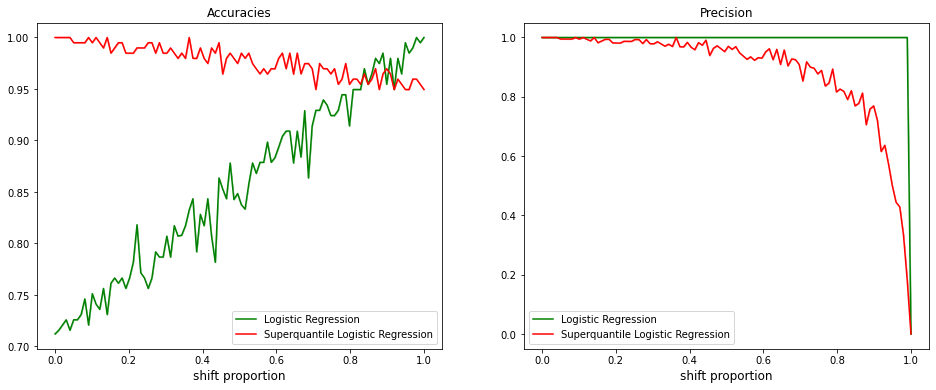

In [113]:
lst_prop = list(np.linspace(0.0,1.0, num=100))
lst_prop = list(map(lambda x: [1-x, x], lst_prop))

lst_accuracy = []
lst_min_accuracy = []
lst_max_accuracy = []

lst_precision = []
lst_min_precision = []
lst_max_precision = []

lst_accuracy2 = []
lst_min_accuracy2 = []
lst_max_accuracy2 = []

lst_precision2 = []
lst_min_precision2 = []
lst_max_precision2 = []

for prop in lst_prop:
    temp_acc = []
    temp_prec = []
    
    temp_acc2 = []
    temp_prec2 = []
    
    shifted_x, shifted_y = subsample(X_val, y_val, prop)
    y_hat = lr.predict(shifted_x)
    y_hat2 = super_clf.predict(shifted_x)
    temp_acc.append(accuracy_score(shifted_y, y_hat))
    temp_prec.append(precision_score(shifted_y, y_hat))
    temp_acc2.append(accuracy_score(shifted_y, y_hat2))
    temp_prec2.append(precision_score(shifted_y, y_hat2))

    max_acc = np.mean(temp_acc) + np.std(temp_acc)
    min_acc = np.mean(temp_acc) - np.std(temp_acc)
    mean_acc = np.mean(temp_acc)
    max_prec = np.mean(temp_prec) + np.std(temp_prec)
    min_prec = np.mean(temp_prec) - np.std(temp_prec)
    mean_prec = np.mean(temp_prec)
    

    max_acc2 = np.mean(temp_acc2) + np.std(temp_acc2)
    min_acc2 = np.mean(temp_acc2) - np.std(temp_acc2)
    mean_acc2 = np.mean(temp_acc2)
    max_prec2 = np.mean(temp_prec2) + np.std(temp_prec2)
    min_prec2 = np.mean(temp_prec2) - np.std(temp_prec2)
    mean_prec2 = np.mean(temp_prec2)
    
    lst_accuracy.append(mean_acc)
    lst_min_accuracy.append(min_acc)
    lst_max_accuracy.append(max_acc)
    lst_precision.append(mean_prec)
    lst_min_precision.append(min_prec)
    lst_max_precision.append(max_prec)
    
    lst_accuracy2.append(mean_acc2)
    lst_min_accuracy2.append(min_acc2)
    lst_max_accuracy2.append(max_acc2)
    lst_precision2.append(mean_prec2)
    lst_min_precision2.append(min_prec2)
    lst_max_precision2.append(max_prec2)
    
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

graph1 = axes[0]
graph1.title.set_text('Accuracies')
graph1.plot([x for x,y in lst_prop], lst_accuracy, color = "g", alpha=1.0, label='Logistic Regression')
graph1.plot([x for x,y in lst_prop], lst_accuracy2, color = "r", alpha=1.0, label='Superquantile Logistic Regression')
graph1.fill_between([x for x,y in lst_prop], lst_min_accuracy, lst_max_accuracy, color = "g", alpha=0.3)
graph1.fill_between([x for x,y in lst_prop], lst_min_accuracy2, lst_max_accuracy2, color = "r", alpha=0.3)
graph1.set_xlabel('shift proportion', fontsize=12)
graph1.legend()

graph2 = axes[1]
graph2.title.set_text('Precision')
graph2.plot([x for x,y in lst_prop], lst_precision, color = "g",  alpha=1.0, label='Logistic Regression')
graph2.plot([x for x,y in lst_prop], lst_precision2, color = "r",  alpha=1.0, label='Superquantile Logistic Regression')
graph2.fill_between([x for x,y in lst_prop], lst_min_precision, lst_max_precision, color = "g", alpha=0.3)
graph2.fill_between([x for x,y in lst_prop], lst_min_precision2, lst_max_precision2, color = "r", alpha=0.3)
graph2.set_xlabel('shift proportion', fontsize=12)
graph2.legend()

plt.show()